In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use GPU

In [19]:
# Set MPS as the device
device = torch.device("mps")

## Load raw data

In [4]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
data_folder = os.path.join(parent_path, "data")
raw_data_path = os.path.join(data_folder, "parquet", "raw", "raw.parquet")
df = pd.read_parquet(raw_data_path)

## Drop T01 - T03 trials

In [5]:
dropids = [
    id for id in df.trial_id.unique() if any(x in id for x in ["T01", "T02", "T03"])
]
df = df.loc[~df["trial_id"].isin(dropids)]

In [6]:
# Scale Data
from sklearn.preprocessing import StandardScaler

non_id_cols = [
    "index",
    "acc_1",
    "acc_2",
    "acc_3",
    "gyr_1",
    "gyr_2",
    "gyr_3",
    "grf_1",
    "grf_2",
    "grf_3",
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[non_id_cols] = scaler.fit_transform(df[non_id_cols])

In [7]:
feature_cols = ["acc_1", "acc_2", "acc_3", "gyr_1", "gyr_2", "gyr_3"]
target_cols = ["grf_1", "grf_2", "grf_3"]

In [55]:
import torch
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch.multiprocessing as mp

# Safe multiprocessing start method
mp.set_start_method("spawn", force=True)

trial_id_list = df_scaled.trial_id.unique().tolist()

train_ids, test_ids = train_test_split(trial_id_list, test_size=0.2)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5)

print(
    f"Train Size:{len(train_ids)}\nVal Size:{len(val_ids)}\nTest Size:{len(test_ids)}\n "
)

# Separate data into the three dfs

train_df = df_scaled.loc[df_scaled.trial_id.isin(train_ids)]
train_df = train_df.reset_index(drop=True)

val_df = df_scaled.loc[df_scaled.trial_id.isin(val_ids)]
val_df = val_df.reset_index(drop=True)

test_df = df_scaled.loc[df_scaled.trial_id.isin(test_ids)]
test_df = test_df.reset_index(drop=True)


# Define Function to split the dfs into X and Y sequences
def prep_sequences(df):

    df_grouped = df.groupby("trial_id")
    X_list = []
    Y_list = []

    for _, trial in df_grouped:
        X_list.append(trial[feature_cols].values)
        Y_list.append(trial[target_cols].values)

    return X_list, Y_list


X_train, Y_train = prep_sequences(train_df)
X_val, Y_val = prep_sequences(val_df)
X_test, Y_test = prep_sequences(test_df)


# Create the Torch Datasets
class CreateDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


train_dataset = CreateDataset(X_train, Y_train)
val_dataset = CreateDataset(X_val, Y_val)
test_dataset = CreateDataset(X_test, Y_test)

# Check datashape
sample_input, sample_output = train_dataset[0]  # Get the first sample
print(f"Input Shape: {sample_input.shape}, Output Shape: {sample_output.shape}")

Train Size:148
Val Size:19
Test Size:19
 
Input Shape: (4500, 6), Output Shape: (4500, 3)


In [56]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


# Define collate function for Dataloader
def collate_fn(batch):

    inputs, outputs = zip(*batch)

    # Convert to tensors
    inputs = [torch.tensor(seq, dtype=torch.float32) for seq in inputs]
    outputs = [torch.tensor(seq, dtype=torch.float32) for seq in outputs]

    # Sort the sequences in descending orders
    lengths = torch.tensor(
        [len(seq) for seq in inputs], dtype=torch.int64
    )  # Get length of each sequence
    lengths, sorted_idx = lengths.sort(descending=True)

    inputs = [inputs[i] for i in sorted_idx]
    outputs = [outputs[i] for i in sorted_idx]

    # Pad the sorted sequence
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=-100)
    outputs_padded = pad_sequence(outputs, batch_first=True, padding_value=-100)

    return inputs_padded, outputs_padded, lengths


# train_dataloader = DataLoader(
#     train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn
# )
# val_dataloader = DataLoader(
#     val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn
# )
# test_dataloader = DataLoader(
#     test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn
# )

In [124]:
# # Define RNN Model
# class RNNModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1):
#         super(RNNModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x, lengths):
#         # Sort the lengths in descending order and get the sorted indices
#         lengths, sorted_idx = lengths.sort(0, descending=True)
#         x = x[sorted_idx]  # Sort the input accordingly
#         x_packed = nn.utils.rnn.pack_padded_sequence(
#             x, lengths, batch_first=True, enforce_sorted=False
#         )

#         out_packed, _ = self.rnn(x_packed)

#         out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)

#         out = self.fc(out)
#         return out

In [21]:
# # Define model training function
# def train_model(
#     model, dataloader, val_dataloader, num_epochs=50, early_stop_patience=10
# ):
#     training_losses = []
#     for epoch in range(num_epochs):

#         epoch_loss = 0.0
#         best_val_loss = np.inf
#         patience_count = 0

#         for inputs, targets, lengths in dataloader:
#             inputs, targets, lengths = (
#                 inputs.to(device),
#                 targets.to(device),
#                 lengths.cpu(),
#             )

#             # Forward pass
#             predictions = model(inputs, lengths)

#             # Mask padded values
#             masks = (targets != -100).float()
#             predictions = predictions * masks
#             targets = targets * masks

#             # Loss Calculation
#             loss = criterion(predictions, targets)
#             loss = loss * masks  # Mask out padded positions
#             loss = loss.sum() / masks.sum()  # Normalize by valid tokens

#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         avg_train_loss = epoch_loss / len(dataloader)
#         training_losses.append(avg_train_loss)

#         val_loss = eval_model(model, val_dataloader)

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_count = 0
#         else:
#             patience_count += 1

#         if patience_count == early_stop_patience:
#             print(f"Early Stop Triggered: Best Validation Loss = {best_val_loss}")
#             return

#         print(
#             f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}"
#         )

#     return model, training_losses, best_val_loss


# def eval_model(model, dataloader):

#     epoch_loss = 0.0

#     for inputs, targets, lengths in dataloader:
#         inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.cpu()

#         # Forward pass
#         predictions = model(inputs, lengths)

#         # Mask padded values
#         masks = (targets != -100).float()
#         predictions = predictions * masks
#         targets = targets * masks

#         # Loss Calculation
#         loss = criterion(predictions, targets)
#         loss = loss * masks
#         loss = loss.sum() / masks.sum()

#         epoch_loss += loss.item()

#     avg_eval_loss = epoch_loss / len(dataloader)

#     return avg_eval_loss


# input_size = X_train[0].shape[1]
# output_size = Y_train[0].shape[1]
# model = RNNModel(
#     input_size=input_size, hidden_size=64, output_size=output_size
# )  # Adjust sizes as needed
# model.to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train_model(
#     model, train_dataloader, val_dataloader, num_epochs=50, early_stop_patience=10
# )

Epoch [1/50], Training Loss: 0.8785, Validation Loss: 0.6852


KeyboardInterrupt: 

## Pytorch Lightning

In [220]:
import pytorch_lightning as pl
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Ensure proper multiprocessing start method
mp.set_start_method("spawn", force=True)

# Assuming the necessary dataset preparation (like X_train, Y_train, etc.) is done


# Define PyTorch Lightning Model
class RNNModel(pl.LightningModule):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        train_dataset,
        val_dataset,
        test_dataset,
    ):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        # Sort the lengths in descending order and get the sorted indices
        lengths, sorted_idx = lengths.sort(0, descending=True)
        x = x[sorted_idx]  # Sort the input accordingly
        x_packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        out_packed, _ = self.rnn(x_packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)

        out = self.fc(out)

        return out

    def training_step(self, batch, batch_idx):
        inputs, targets, lengths = batch
        lengths = lengths.cpu()
        predictions = self(inputs, lengths)

        # Mask padded values (if needed)
        masks = (targets != -100).float()
        predictions = predictions * masks
        targets = targets * masks

        loss = nn.MSELoss()(predictions, targets)
        loss = loss * masks
        loss = loss.sum() / masks.sum()  # Normalize by valid tokens
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets, lengths = batch
        lengths = lengths.cpu()
        predictions = self(inputs, lengths)

        # Mask padded values (if needed)
        masks = (targets != -100).float()
        predictions = predictions * masks
        targets = targets * masks

        loss = nn.MSELoss()(predictions, targets)
        loss = loss * masks
        loss = loss.sum() / masks.sum()  # Normalize by valid tokens ##TODO log
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        inputs, targets, lengths = batch
        lengths = lengths.cpu()
        predictions = self(inputs, lengths)
        # Mask padded values (if needed)
        masks = (targets != -100).float()
        predictions = predictions * masks
        targets = targets * masks

        loss = nn.MSELoss()(predictions, targets)
        loss = loss * masks
        loss = loss.sum() / masks.sum()  # Normalize by valid tokens
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        # print(f"Test Loss: {loss}")
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def train_dataloader(self):
        return DataLoader(
            train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
        )

    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)


# Instantiate the model
input_size = X_train[0].shape[1]
output_size = Y_train[0].shape[1]
model = RNNModel(
    input_size=input_size,
    hidden_size=64,
    output_size=output_size,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
)

# PyTorch Lightning Trainer
trainer = pl.Trainer(
    accelerator="mps", max_epochs=100, callbacks=None, log_every_n_steps=10  # Debug
)

# Fit the model
trainer.fit(model)

# # Test the model
test_loss = trainer.test(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type   | Params | Mode 
----------------------------------------
0 | rnn  | RNN    | 4.6 K  | train
1 | fc   | Linear | 195    | train
----------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/marco/opt/anaconda3/envs/DS/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/marco/opt/anaconda3/envs/DS/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/marco/opt/anaconda3/envs/DS/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 3/3 [00:07<00:00,  0.41it/s, v_num=61, train_loss_step=0.213, train_loss_epoch=0.174]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:07<00:00,  0.41it/s, v_num=61, train_loss_step=0.213, train_loss_epoch=0.174]

/Users/marco/opt/anaconda3/envs/DS/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        0.1454593986272812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Test set

In [145]:
# set model to eval mode
model.to(device)
model.eval()

# Selecte test dataloader
test_dataloader = model.test_dataloader()

predictions_list = []
targets_list = []

with torch.no_grad():
    for inputs, targets, lengths in test_dataloader:
        inputs, targets, lengths = inputs.to(device), targets.to(device), lengths.cpu()

        predictions = model(inputs, lengths)
        masks = (targets != -100).float()

        predictions = predictions * masks
        targets = targets * masks

        predictions_list.append(predictions.cpu())
        targets_list.append(targets.cpu())

# Contatenate results
predictions_list = torch.cat(predictions_list, dim=0)
targets_list = torch.cat(targets_list, dim=0)

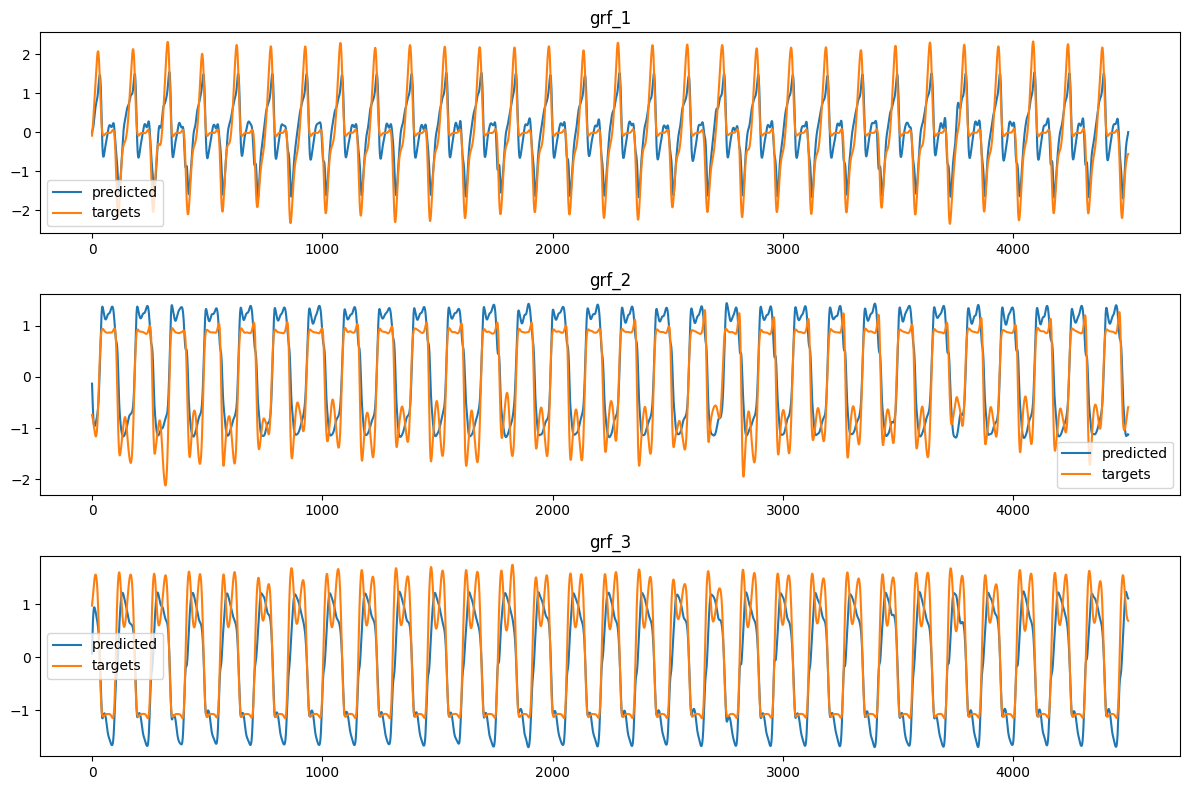

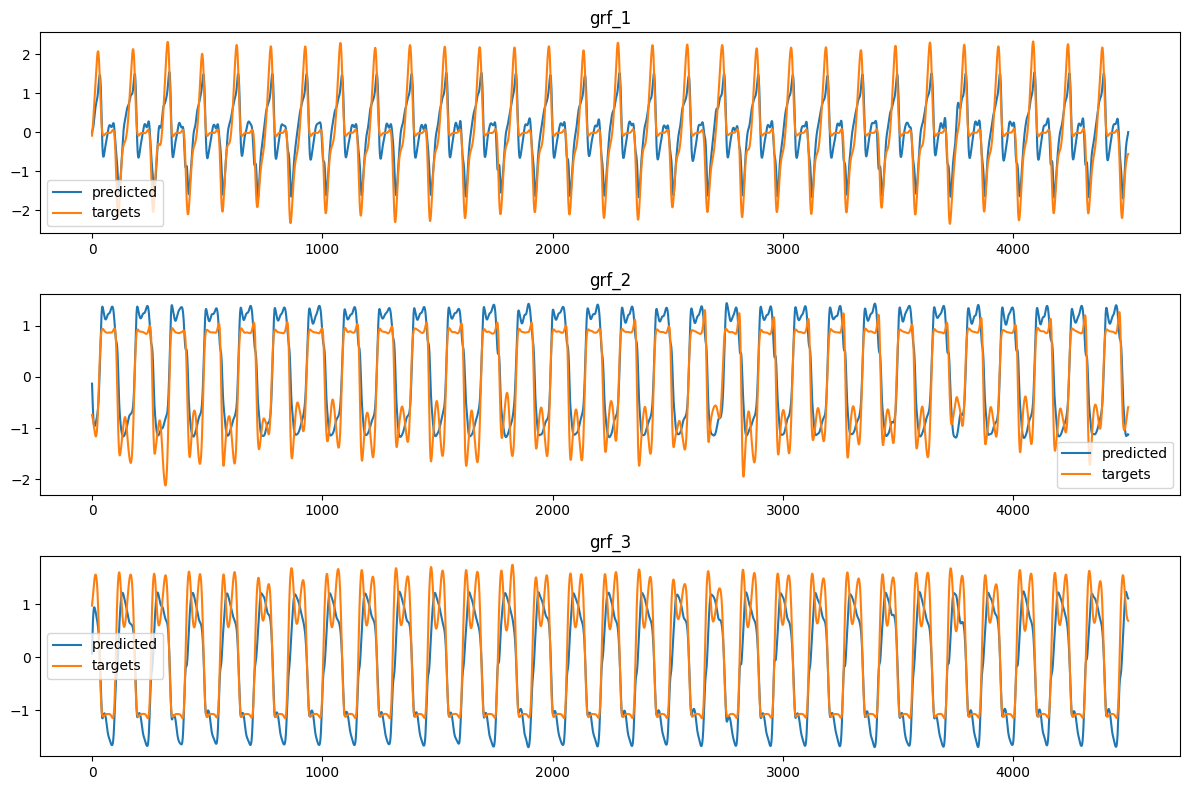

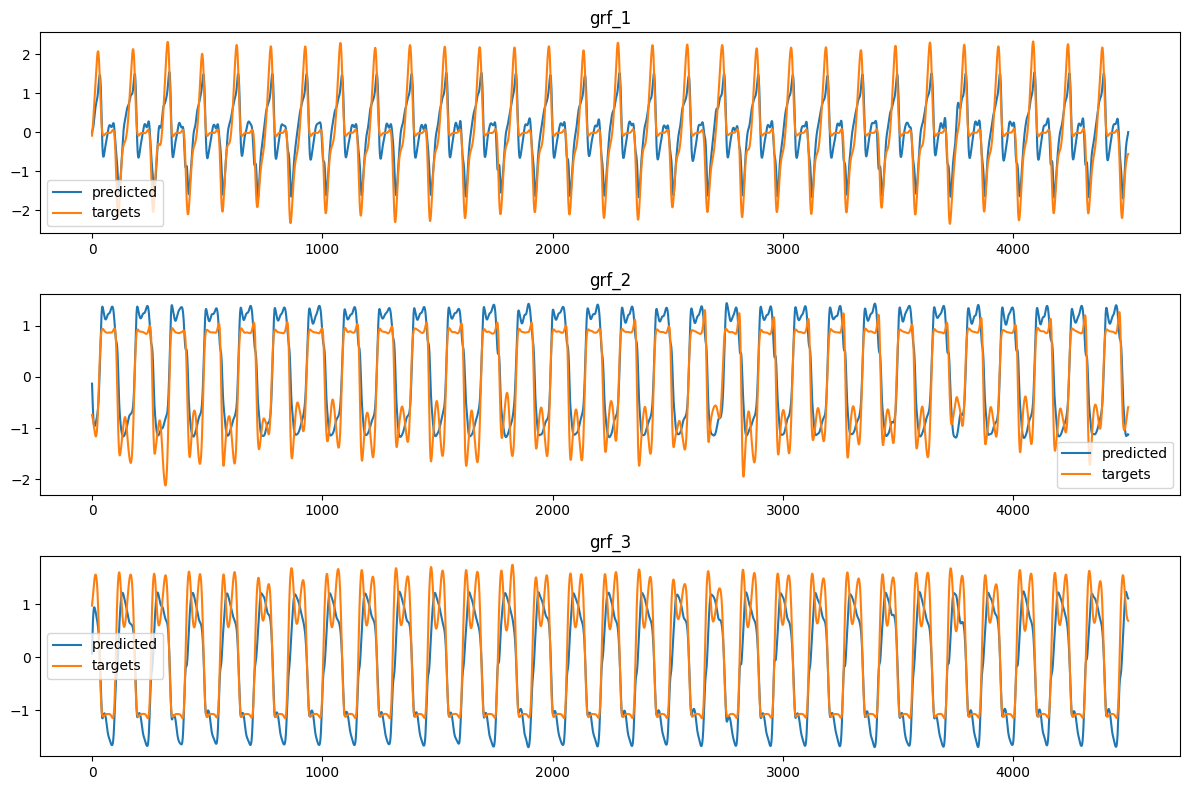

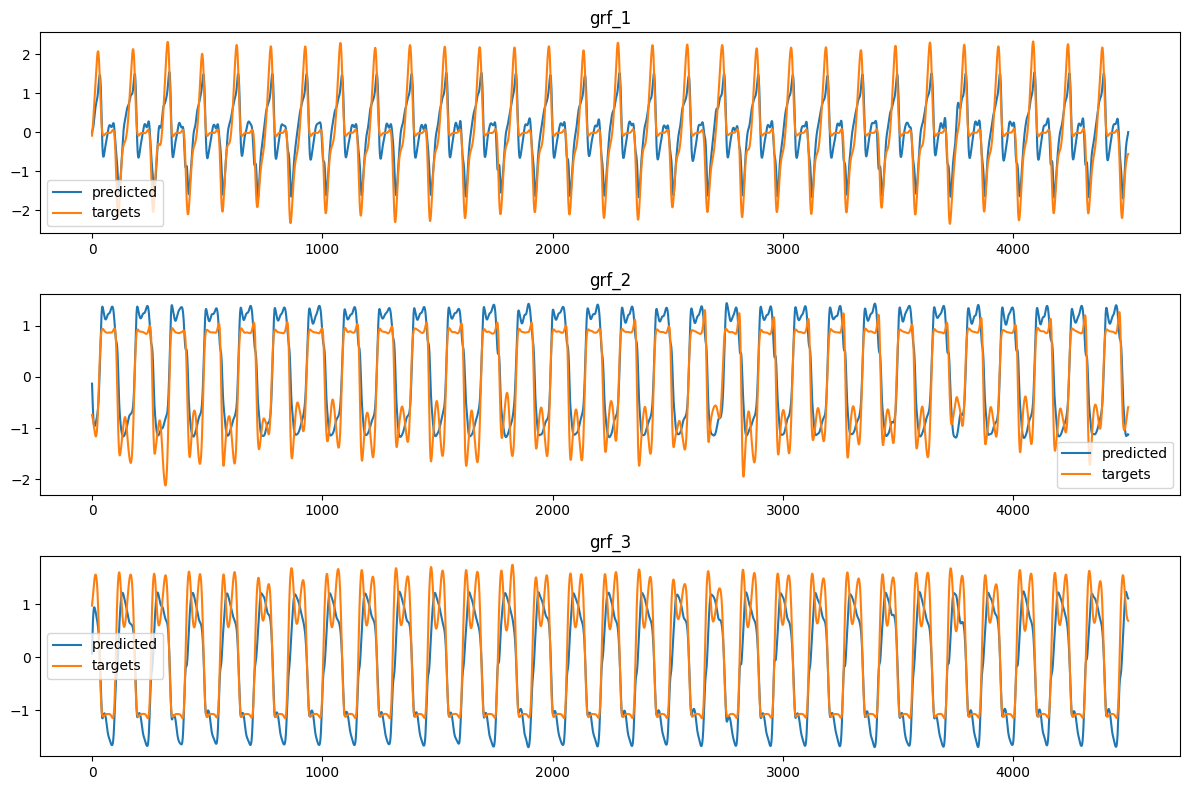

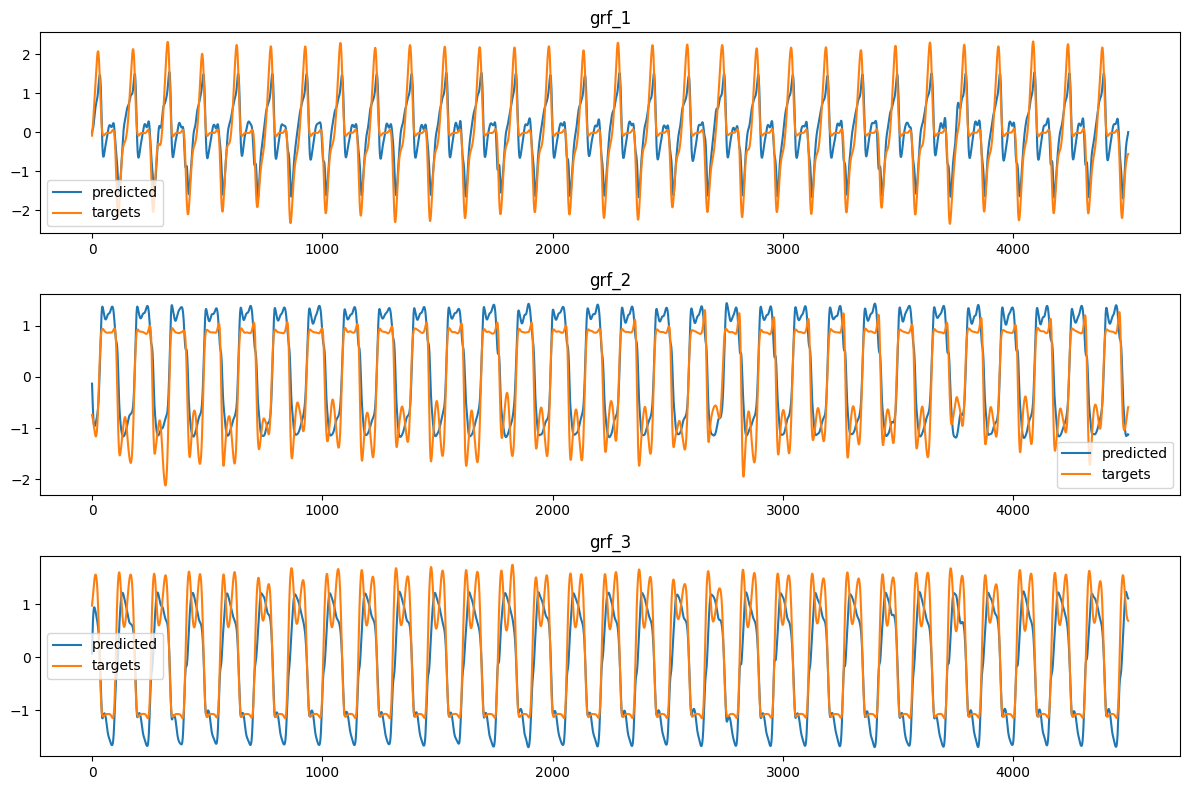

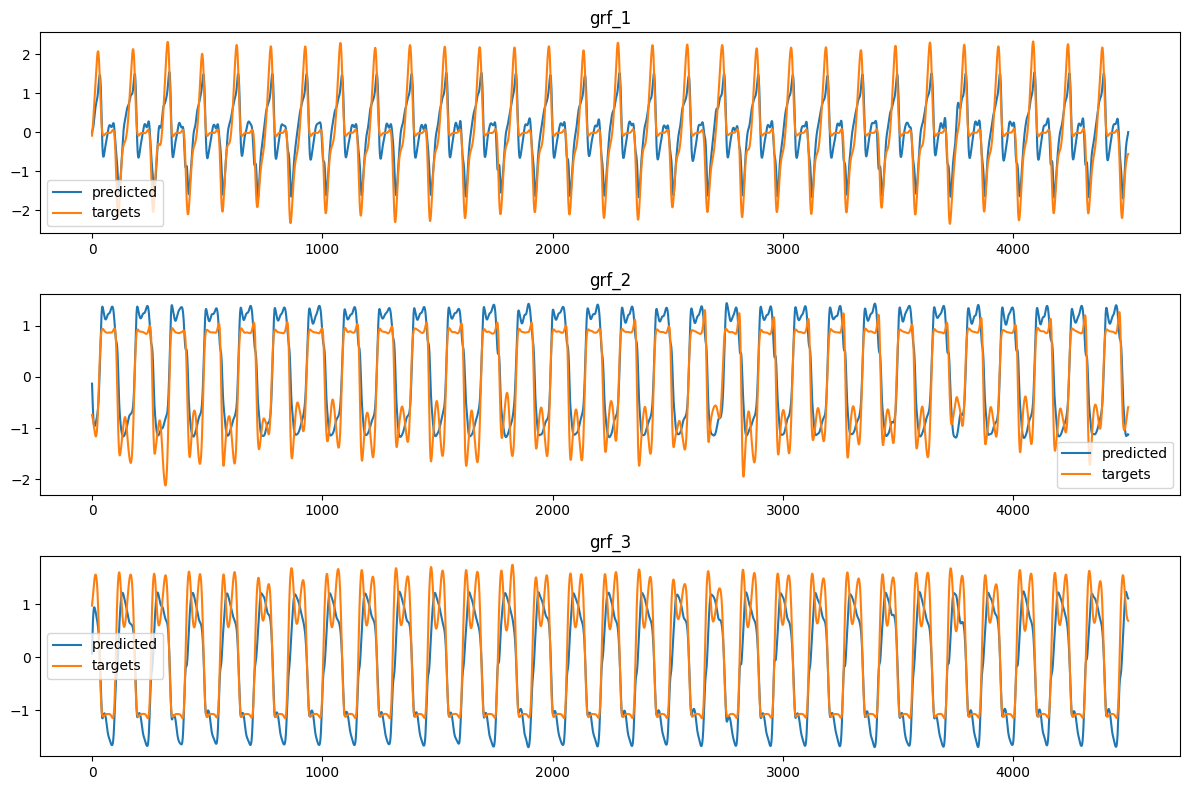

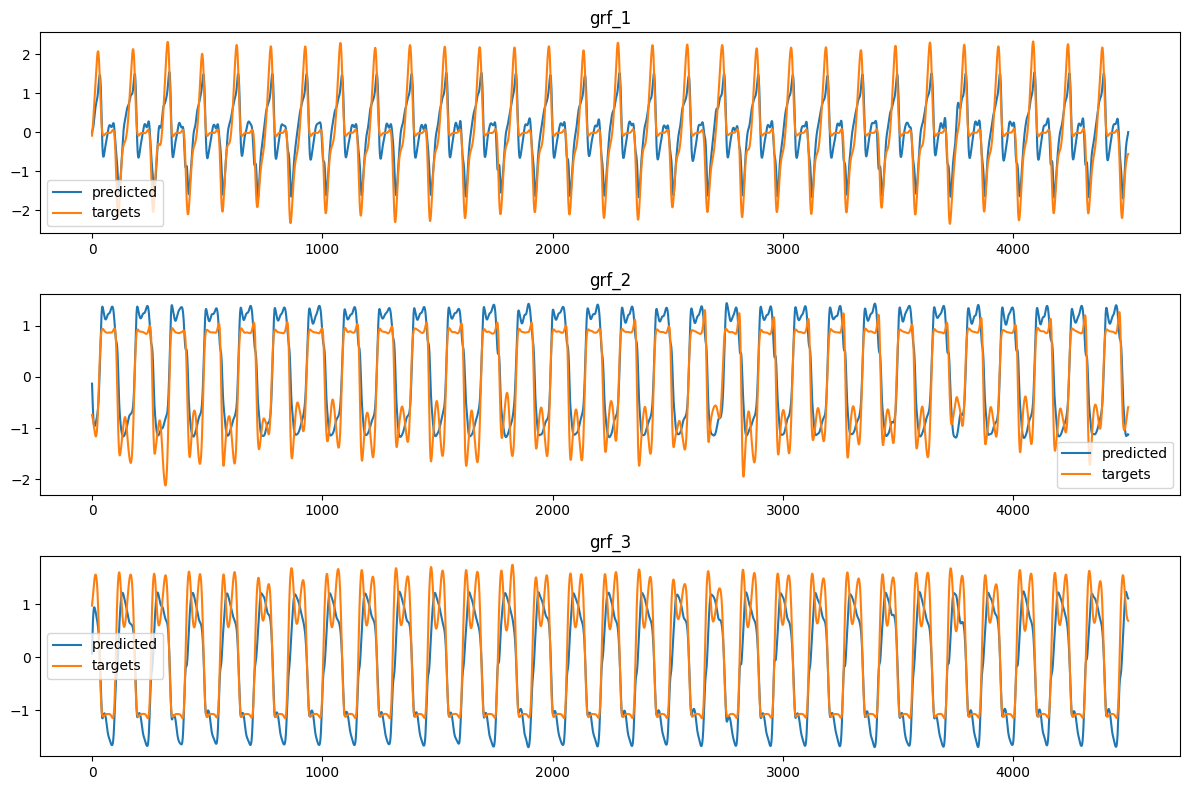

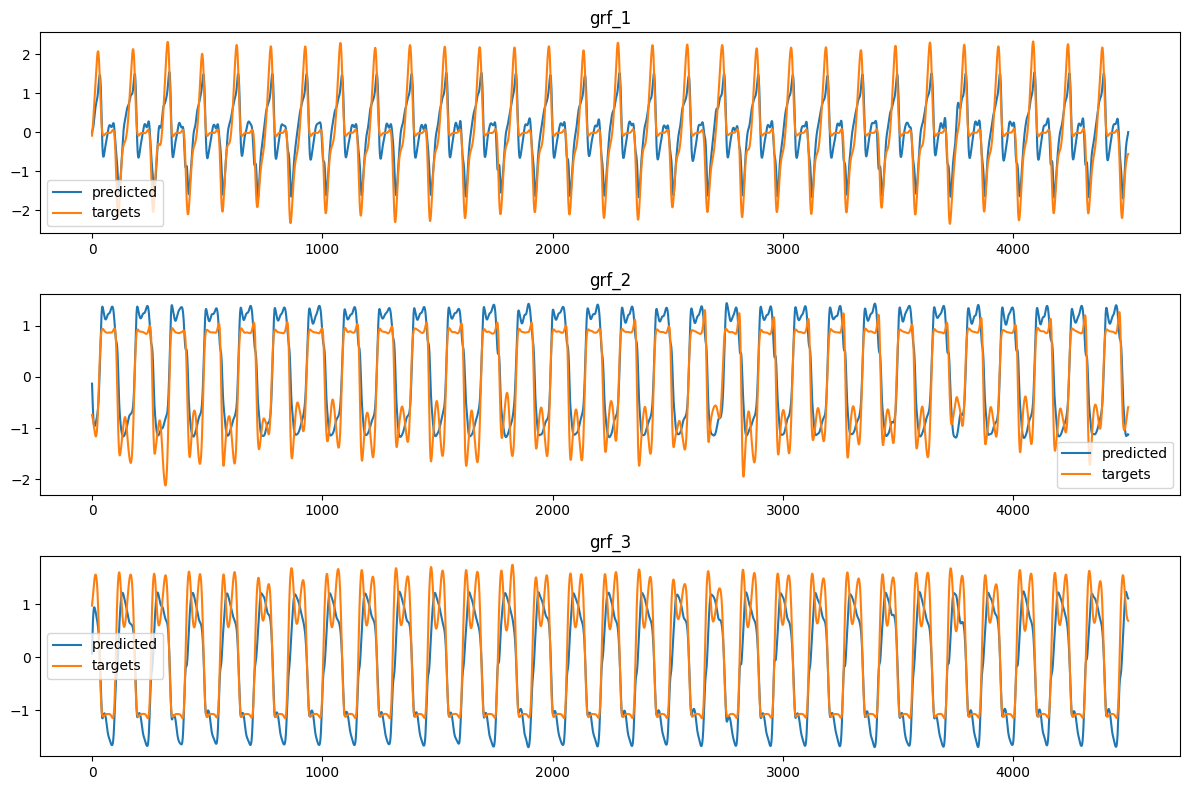

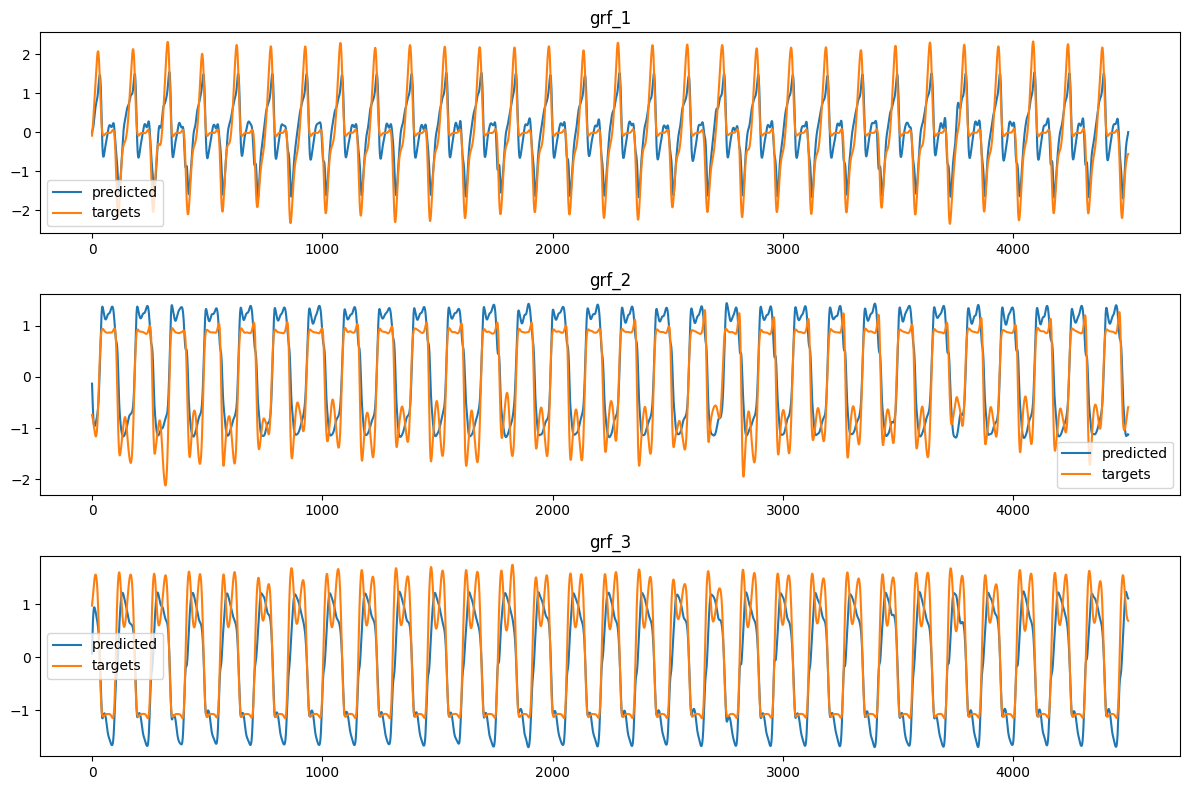

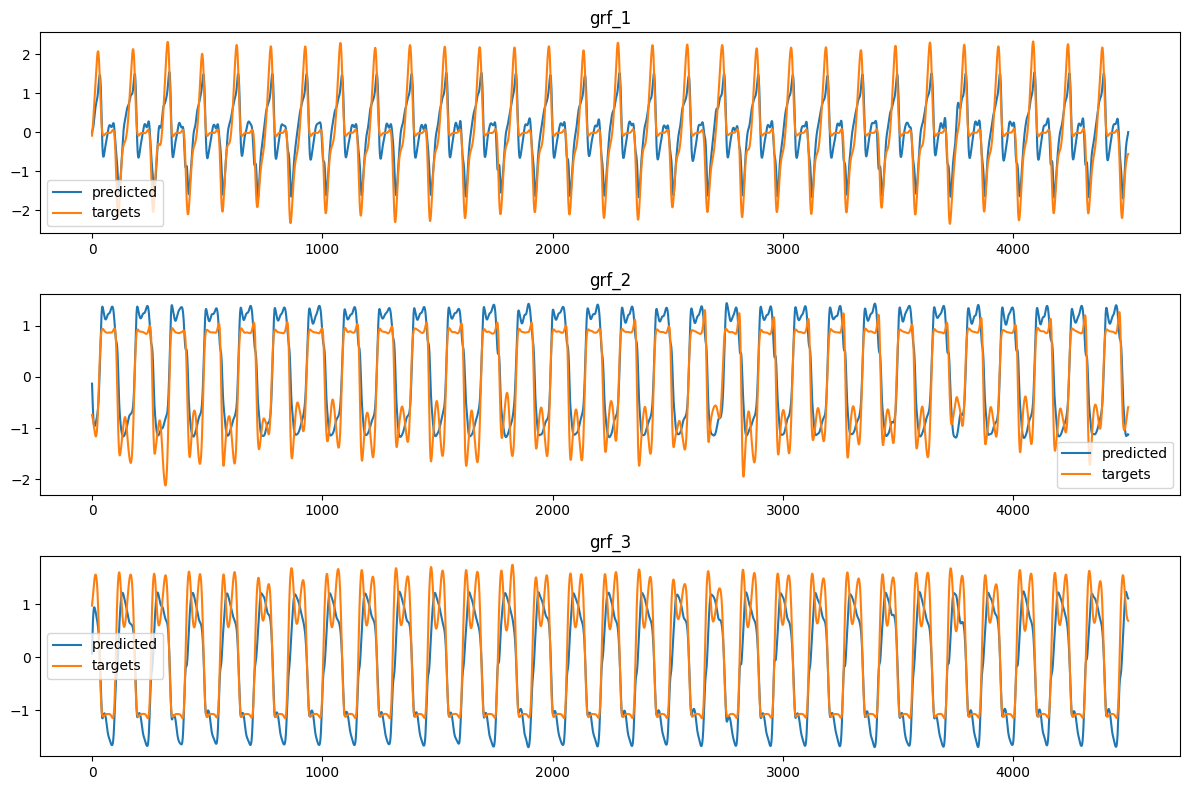

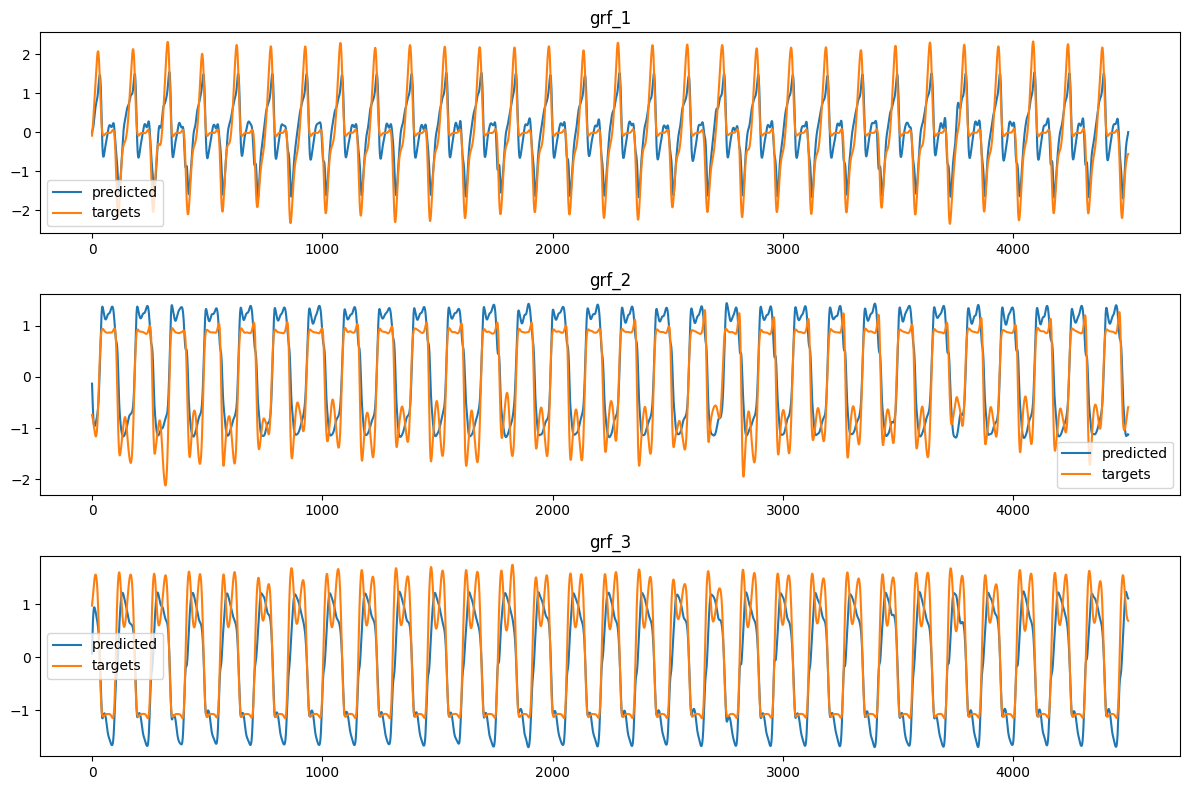

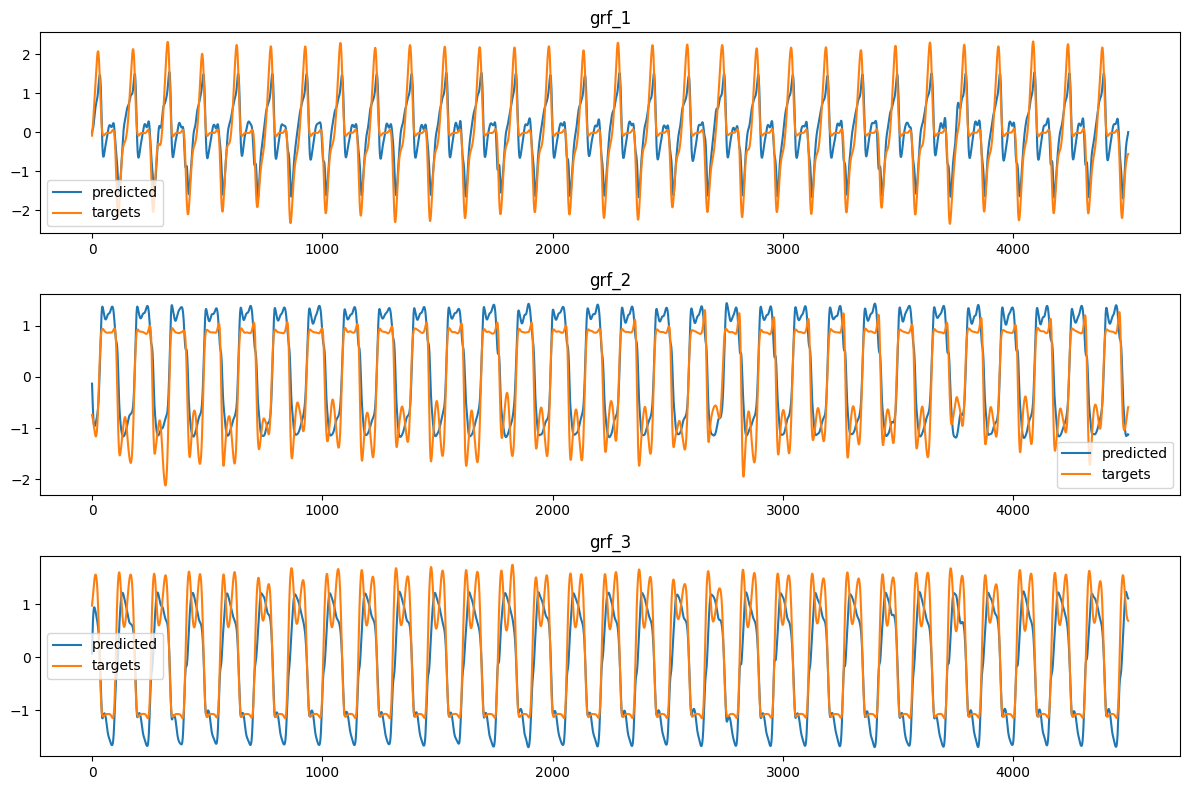

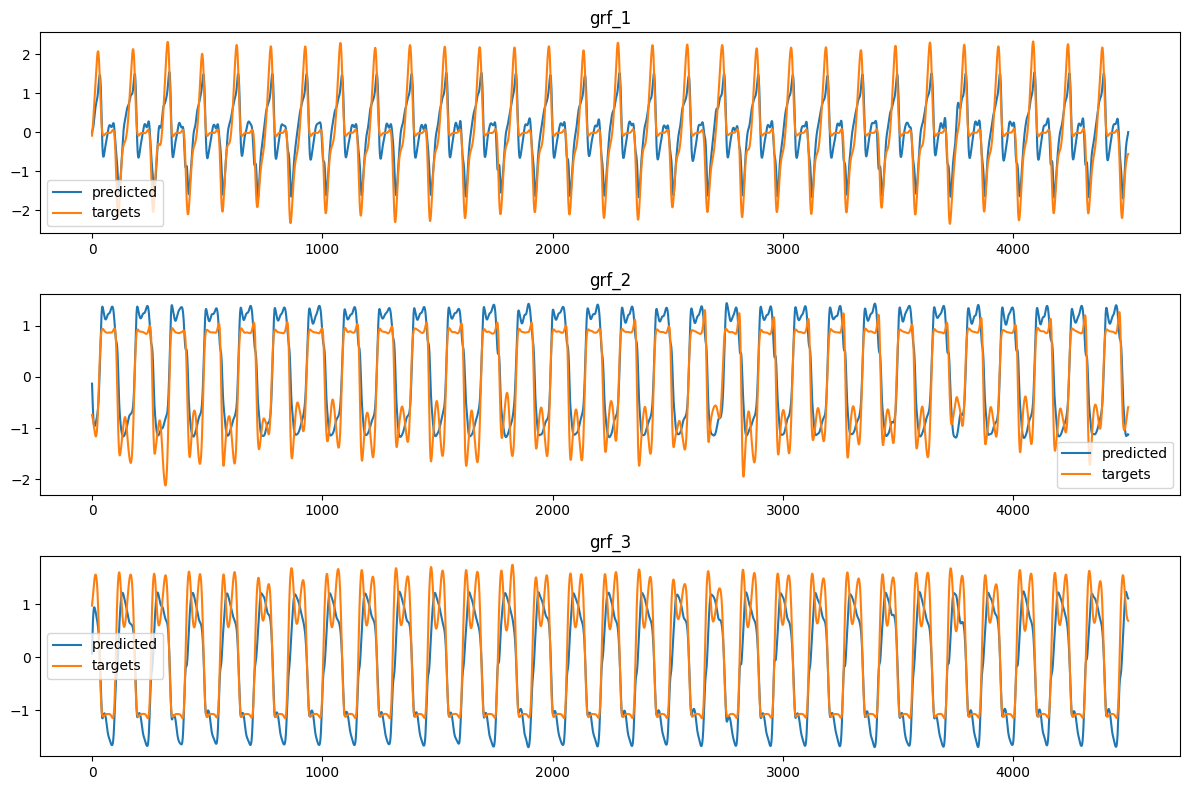

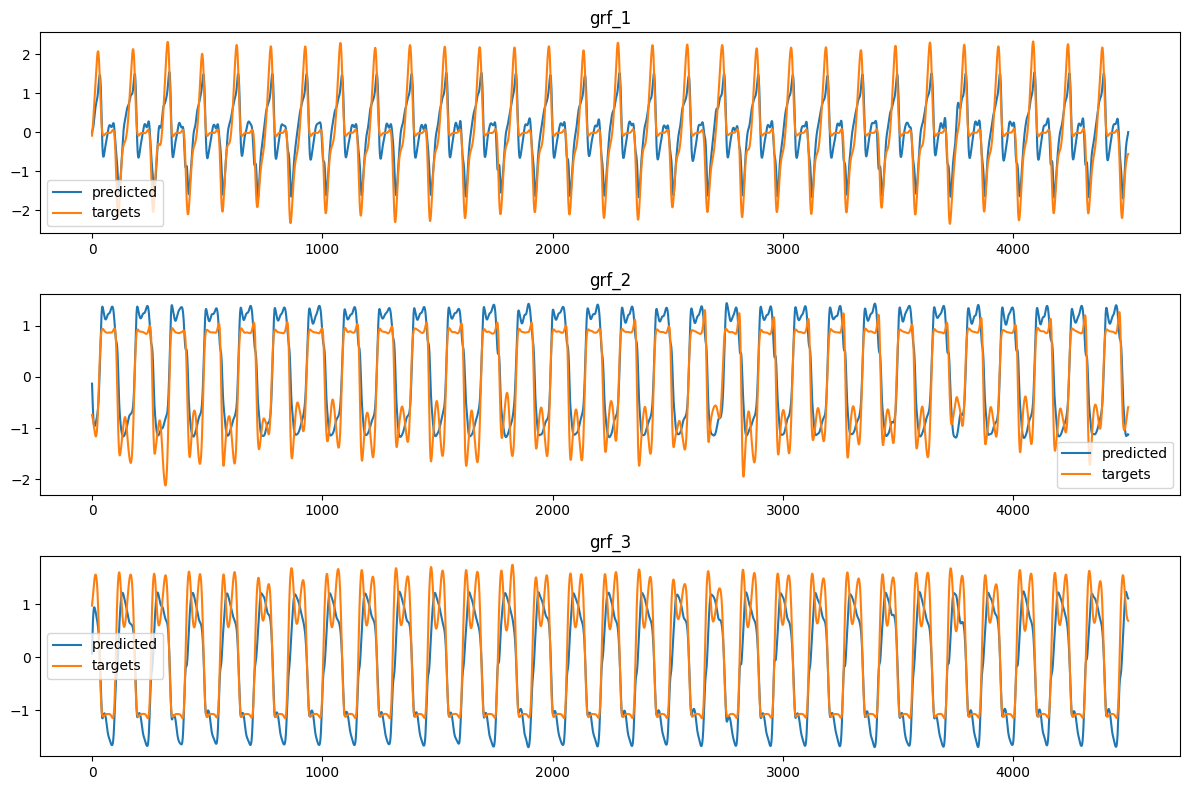

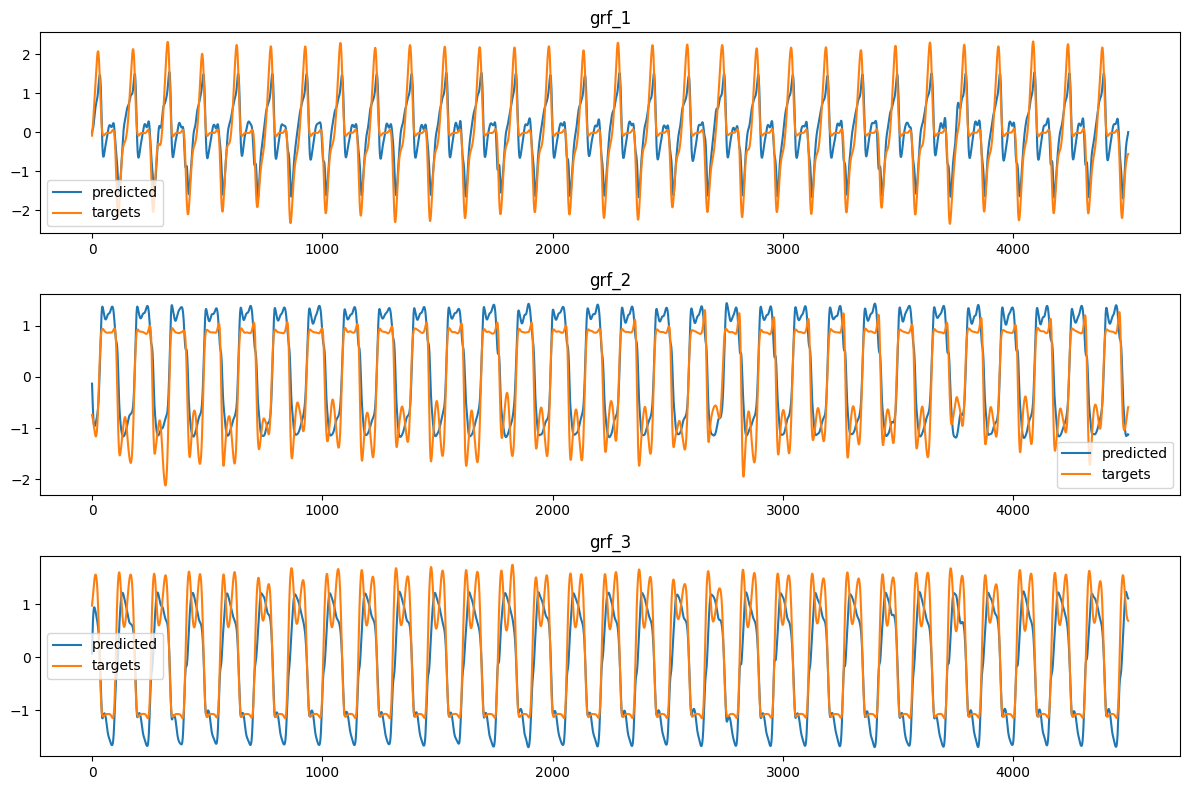

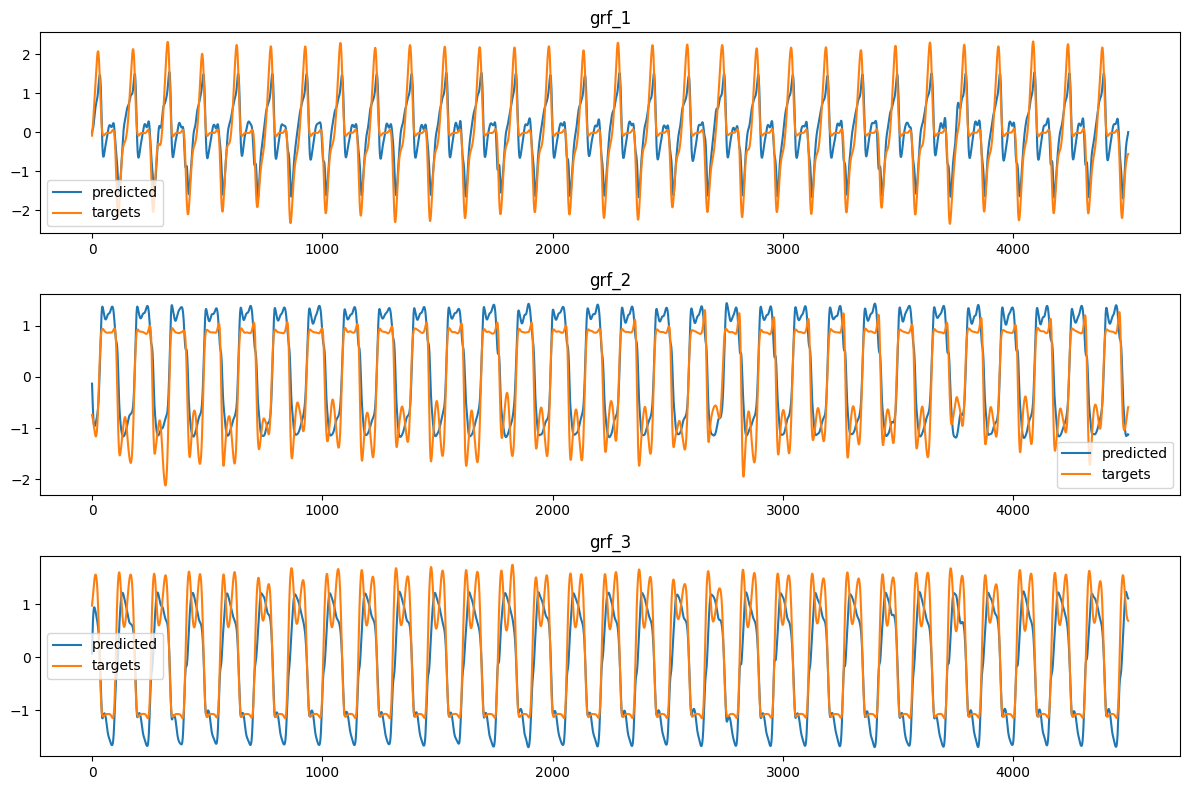

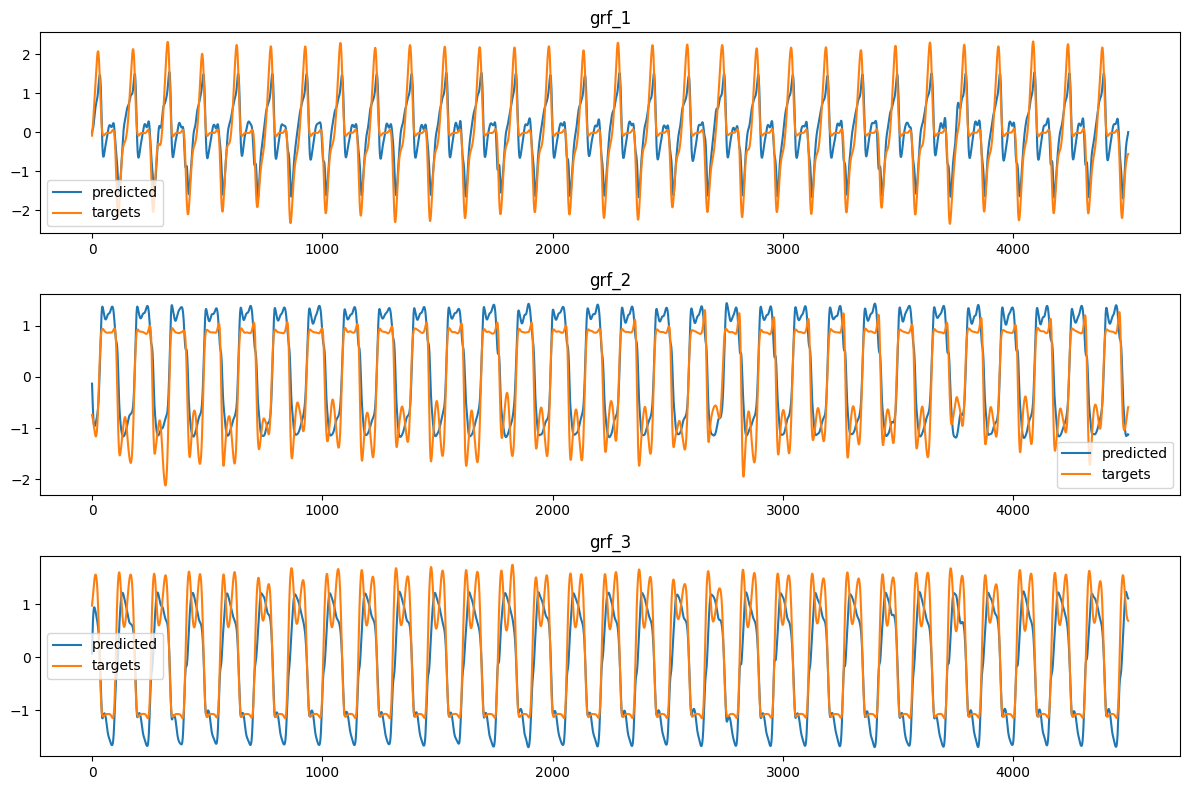

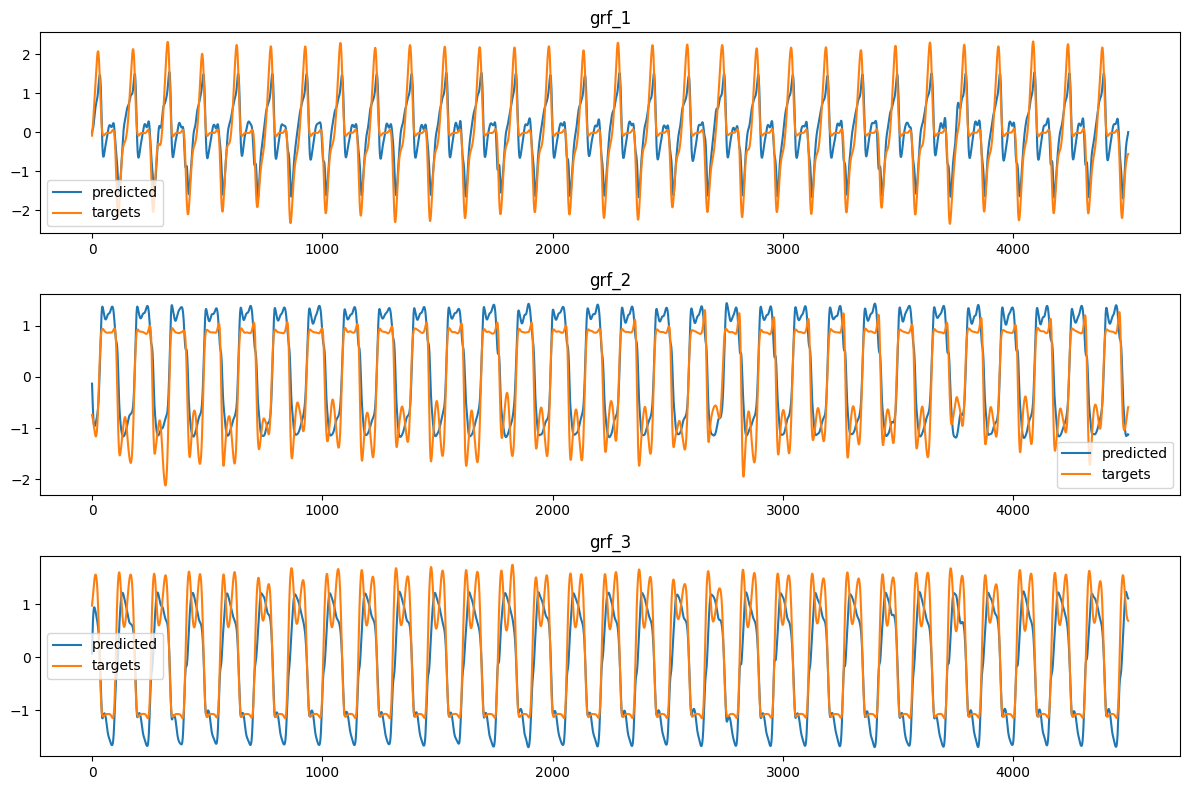

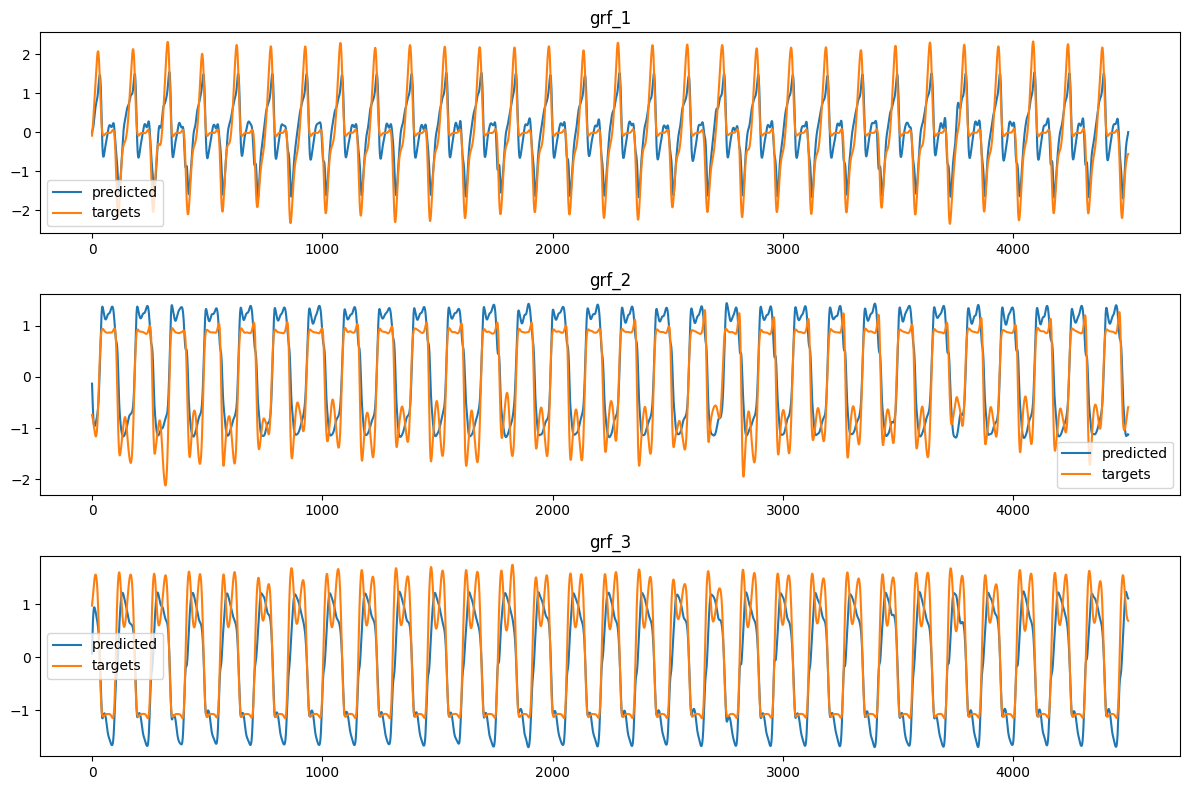

In [222]:
# Plot test sets predictions
for plot_idx in range(len(predictions_list)):
    plot_idx = 0

    plot_prediction = predictions_list[plot_idx].numpy()
    plot_target = targets_list[plot_idx].numpy()

    plot_prediction = pd.DataFrame(plot_prediction, columns=target_cols)
    plot_target = pd.DataFrame(plot_target, columns=target_cols)

    fig, axes = plt.subplots(
        ncols=1, nrows=len(plot_prediction.columns), figsize=(12, 8)
    )

    col_2_plot = plot_prediction.columns

    for i in range(len(axes)):
        axes[i].plot(plot_prediction[col_2_plot[i]].values, label="predicted")
        axes[i].plot(plot_target[col_2_plot[i]].values, label="targets")
        axes[i].legend()
        axes[i].set_title(col_2_plot[i])
    # Show the plot
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

In [ ]:
# jupyter nbconvert --to script --no-prompt models_training.ipynb